In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
import torchvision.models as models
import numpy as np
from math import floor
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [2]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [31]:
# LeNet Model definition
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [32]:
# Initialize the network
model = LeNet()
pretrained_model = "data/lenet_mnist_model.pth"
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [33]:
# PGD attacker

def PGD(model, x, y, num_steps, step_size, eps, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True).to('cpu')
    num_channels = x.shape[1]

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        pred = model(_x_adv)
        loss = F.nll_loss(pred, y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            gradients = _x_adv.grad.sign() * step_size
            x_adv += gradients # Untargeted PGD
            
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps) # Project shift to L_inf norm ball
        x_adv = torch.clamp(x_adv,0,1) #set output to correct range

    return x_adv.detach()

In [50]:
def test( model, test_loader,step_size, eps):
    correct = 0
    adv_examples = []

    for data, label in test_loader:
        output = model(data)  # Forward pass 
        init_pred = output.max(1, keepdim=True)[1] # get the initial prediction
        
        if init_pred.item() != label.item():  # Only bother to attck if initial prediction is correct
            continue
            
        perturbed_data = PGD(model,data,label,10,step_size,eps)
        
        output = model(perturbed_data) # Re-classify the perturbed image
        final_pred = output.max(1, keepdim=True)[1] # get the new prediction

        if final_pred.item() == label.item(): # Check for success
            correct += 1

            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples
    return final_acc, adv_examples

In [51]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
step_size = 0.02
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_loader, step_size, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9295 / 10000 = 0.9295
Epsilon: 0.1	Test Accuracy = 7637 / 10000 = 0.7637
Epsilon: 0.15	Test Accuracy = 4555 / 10000 = 0.4555
Epsilon: 0.2	Test Accuracy = 1806 / 10000 = 0.1806
Epsilon: 0.25	Test Accuracy = 1806 / 10000 = 0.1806
Epsilon: 0.3	Test Accuracy = 1806 / 10000 = 0.1806


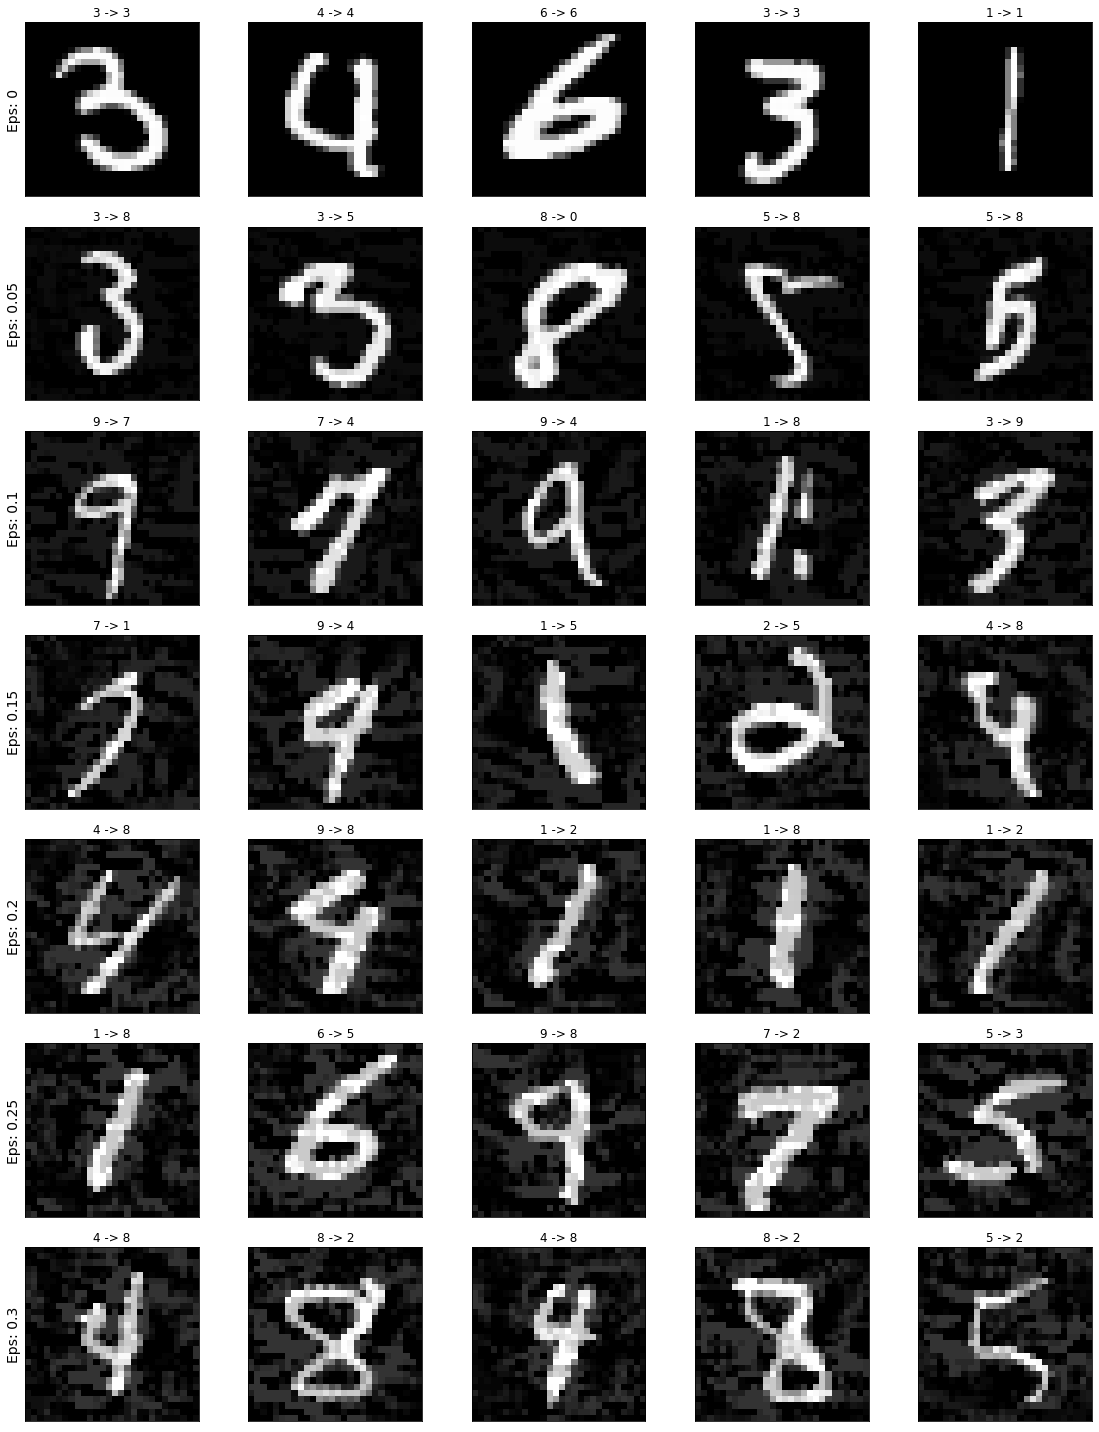

In [52]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(16,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

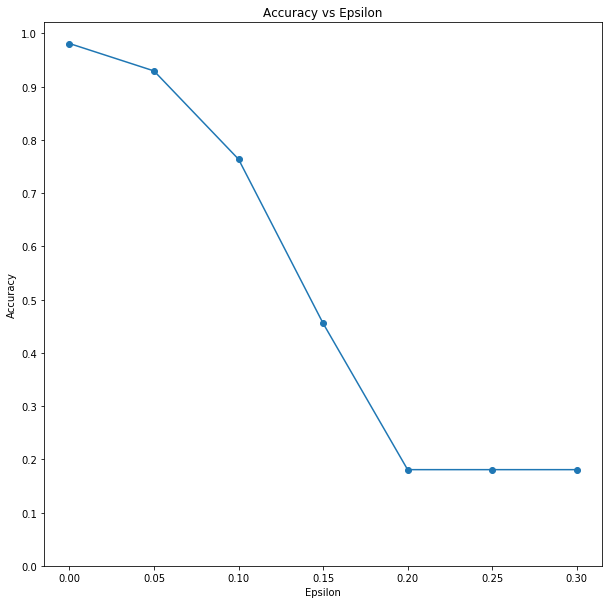

In [53]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies,'-o')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")